In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

import os
from pathlib import Path
import torch
import tokenizers as tk
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import transforms
from torch import nn, Tensor
from functools import partial
from bs4 import BeautifulSoup as bs

from src.model import EncoderDecoder, ImgLinearBackbone, Encoder, Decoder
from src.utils import subsequent_mask, pred_token_within_range, greedy_sampling, bbox_str_to_token_list, cell_str_to_token_list, html_str_to_token_list, build_table_from_html_and_cell, html_table_template
from src.trainer.utils import VALID_HTML_TOKEN, VALID_BBOX_TOKEN, INVALID_CELL_TOKEN

device = torch.device("cuda:5")

/tmp/ipykernel_62978/3082305526.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/home/speng65/anaconda3/envs/adp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


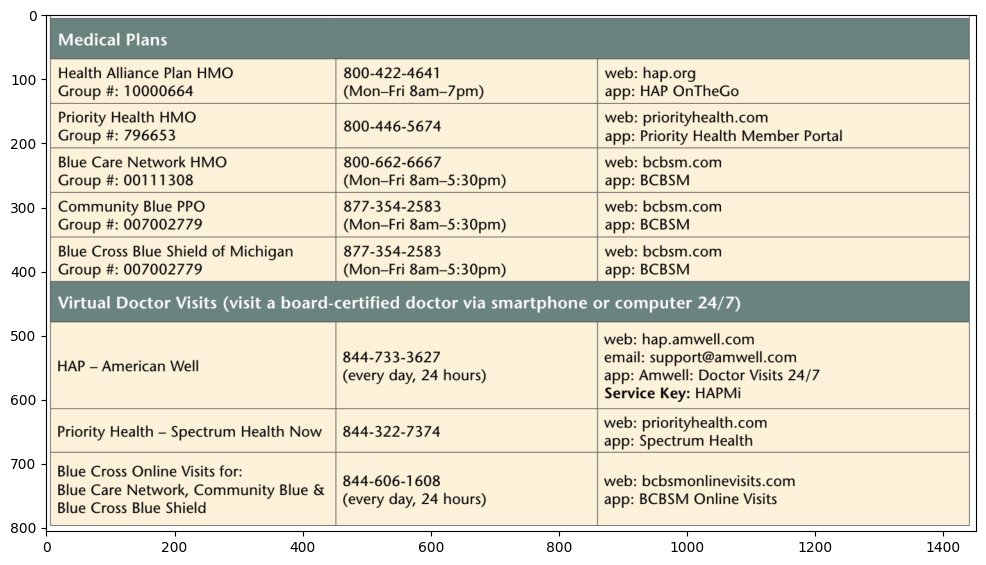

In [2]:
# load image
image_path = "/raid/speng65/MISC/adp_tables/notebooks/adp-testset/p1.png"
image = Image.open(image_path).convert("RGB")
image_size = image.size

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(image)

In [3]:
# model
d_model = 768
patch_size = 16
nhead = 12
dropout = 0.2

backbone = ImgLinearBackbone(d_model=d_model, patch_size=patch_size)

encoder = Encoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=12,
    ff_ratio=4,
)

decoder = Decoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=4,
    ff_ratio=4,
)


/home/speng65/anaconda3/envs/adp/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
def autoregressive_decode(model: EncoderDecoder, image, prefix, max_decode_len, eos_id, token_whitelist = None, token_blacklist = None):
    model.eval()
    with torch.no_grad():
        memory = model.encode(image)
        context = torch.tensor(prefix, dtype=torch.int32).repeat(image.shape[0], 1).to(device)

    for _ in range(max_decode_len):
        eos_flag = [eos_id in k for k in context]
        if all(eos_flag):
            break

        with torch.no_grad():
            causal_mask = subsequent_mask(context.shape[1]).to(device)
            logits = model.decode(
                memory, context, tgt_mask=causal_mask, tgt_padding_mask=None
            )
            logits = model.generator(logits)[:, -1, :]

        logits = pred_token_within_range(
            logits.detach(),
            white_list=token_whitelist,
            black_list=token_blacklist,
        )

        next_probs, next_tokens = greedy_sampling(logits)
        context = torch.cat([context, next_tokens], dim=1)

    return context

def load_vocab_and_model(vocab_path, max_seq_len, model_weights):
    vocab = tk.Tokenizer.from_file(vocab_path)
    model = EncoderDecoder(
        backbone=backbone,
        encoder=encoder,
        decoder=decoder,
        vocab_size=vocab.get_vocab_size(),
        d_model=d_model,
        padding_idx=vocab.token_to_id("<pad>"),
        max_seq_len=max_seq_len,
        dropout=dropout,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )

    model.load_state_dict(torch.load(model_weights, map_location="cpu"))
    model = model.to(device)

    return vocab, model

def image_to_tensor(image, size):
    T = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.86597056,0.88463002,0.87491087], std = [0.20686628,0.18201602,0.18485524])
    ])
    image_tensor = T(image)

    image_tensor = image_tensor.to(device).unsqueeze(0)

    return image_tensor

def rescale_bbox(bbox, src, tgt):
    assert len(src) == len(tgt) == 2
    ratio = [tgt[0] / src[0], tgt[1] / src[1]] * 2
    bbox = [[int(round(i * j)) for i, j in zip(entry, ratio)] for entry in bbox]
    return bbox

In [5]:
# html
vocab, model = load_vocab_and_model(
    vocab_path = "/raid/speng65/MISC/adp_tables/vocab/vocab_html.json",
    max_seq_len = 784,
    model_weights="/raid/speng65/MISC/adp_tables/experiments/ssp_2m_syn_pub_html_medium/model/best.pt"
)

# image to tensor
image_tensor = image_to_tensor(image, size=(448, 448))

# inference
pred_html = autoregressive_decode(
    model=model, 
    image=image_tensor, 
    prefix=[vocab.token_to_id("[html]")], 
    max_decode_len=512,
    eos_id=vocab.token_to_id("<eos>"), 
    token_whitelist=[vocab.token_to_id(i) for i in VALID_HTML_TOKEN], 
    token_blacklist = None
)

# decode
pred_html = pred_html.detach().cpu().numpy()[0]
pred_html = vocab.decode(pred_html, skip_special_tokens=False)

pred_html = html_str_to_token_list(pred_html)

In [6]:
pred_html

['<thead>',
 '<tr>',
 '<td',
 '  ',
 'colspan="3"',
 '>[]</td>',
 '</tr>',
 '</thead>',
 '<tbody>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td',
 '  ',
 'colspan="3"',
 '>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '<tr>',
 '<td>[]</td>',
 '<td>[]</td>',
 '<td>[]</td>',
 '</tr>',
 '</tbody>']

In [7]:
# bbox
vocab, model = load_vocab_and_model(
    vocab_path = "/raid/speng65/MISC/adp_tables/vocab/vocab_bbox.json",
    max_seq_len = 1024,
    model_weights="/raid/speng65/MISC/adp_tables/experiments/ssp_2m_syn_pub_bbox_medium/model/best.pt"
)

# image to tensor
image_tensor = image_to_tensor(image, size=(448, 448))

# inference
pred_bbox = autoregressive_decode(
    model=model, 
    image=image_tensor, 
    prefix=[vocab.token_to_id("[bbox]")], 
    max_decode_len=1024,
    eos_id=vocab.token_to_id("<eos>"), 
    token_whitelist=[vocab.token_to_id(i) for i in VALID_BBOX_TOKEN[: 449]],
    token_blacklist = None
)

# decode
pred_bbox = pred_bbox.detach().cpu().numpy()[0]
pred_bbox = vocab.decode(pred_bbox, skip_special_tokens=False)

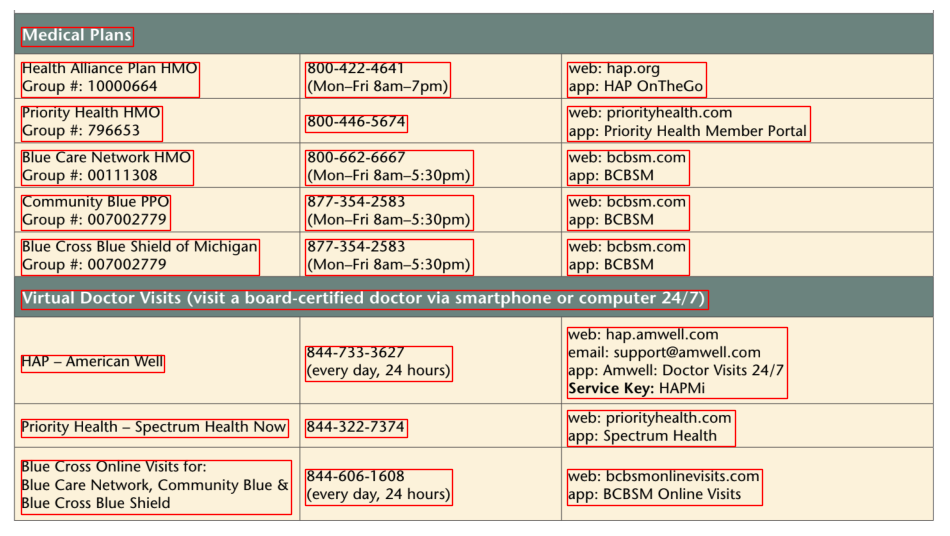

In [8]:
pred_bbox = bbox_str_to_token_list(pred_bbox)
pred_bbox = rescale_bbox(pred_bbox, src=(448, 448), tgt=image_size)

# Table image
fig, ax = plt.subplots(figsize=(12, 10))

for i in pred_bbox:
    rect = patches.Rectangle(i[:2], i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_axis_off()
ax.imshow(image)

plt.savefig("t1-bbox.png", bbox_inches="tight", dpi=200)

In [9]:
# cell
vocab, model = load_vocab_and_model(
    vocab_path = "/raid/speng65/MISC/adp_tables/vocab/vocab_cell_6k.json",
    max_seq_len = 200,
    model_weights="/raid/speng65/MISC/adp_tables/experiments/syn_pub_pub1m_cell_medium/model/best.pt"
)

# image to tensor
image_tensor = [image_to_tensor(image.crop(bbox), size=(112, 448)) for bbox in pred_bbox]
image_tensor = torch.cat(image_tensor, dim=0)

# inference
pred_cell = autoregressive_decode(
    model=model, 
    image=image_tensor, 
    prefix=[vocab.token_to_id("[cell]")], 
    max_decode_len=200,
    eos_id=vocab.token_to_id("<eos>"), 
    token_whitelist=None,
    token_blacklist = [vocab.token_to_id(i) for i in INVALID_CELL_TOKEN]
)

# decode
pred_cell = pred_cell.detach().cpu().numpy()
pred_cell = vocab.decode_batch(pred_cell, skip_special_tokens=False)

pred_cell = [cell_str_to_token_list(i) for i in pred_cell]


In [10]:
table_code = build_table_from_html_and_cell(pred_html, pred_cell)
table_code = "".join(table_code)
table_code = html_table_template(table_code)

# prettify the html + display
soup = bs(table_code)
table_code = soup.prettify()
display(HTML(table_code))

In [12]:
print(table_code)

<html>
 <head>
  <meta charset="utf-8"/>
  <style>
   table, th, td {
            border: 1px solid black;
            font-size: 10px;
        }
  </style>
 </head>
 <body>
  <table frame="hsides" rules="groups" width="100%%">
   <thead>
    <tr>
     <td colspan="3">
      Medical Plans
     </td>
    </tr>
   </thead>
   <tbody>
    <tr>
     <td>
      Health Alliance Plan HMO Croup #: 10000664
     </td>
     <td>
      800 – 422 – 4641 ( Mon – Fri 8am – 7pm )
     </td>
     <td>
      web : hap. orgapp : HAP_OnTheGo
     </td>
    </tr>
    <tr>
     <td>
      Priority Health HMO Group #: 796653
     </td>
     <td>
      800 - 446 - 5674
     </td>
     <td>
      web : priorityhealth. comapp : Priority. Health Member Portal
     </td>
    </tr>
    <tr>
     <td>
      Blue Care Network HMO Croup #: 00111308
     </td>
     <td>
      800 - 662 - 66667 ( Mon – Fri 8am – 5 : 30pm )
     </td>
     <td>
      web : bcbsm. commapp : BCBSM
     </td>
    </tr>
    <tr>
     <td>
